# Plan
- Run Stage 1 Model on test data -> keep true positives <br>
- Run T5 Summary Model on Stage 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load libraries
!pip install pydot --quiet
!pip install gensim --quiet

!pip install --upgrade gspread gspread-dataframe --quiet
!pip install evaluate --quiet
!pip install rouge_score --quiet
!pip install bert-score --quiet
!pip install safetensors --quiet
!python -m spacy download en_core_web_lg --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587

In [ ]:
#@title Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
#import tensorflow_datasets as tfds
# import tensorflow_text as tf_text
import transformers

from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
from sklearn.model_selection import train_test_split
import os

import nltk
from nltk.data import find
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

import time
from google.colab import files
from google.colab import drive

!pip install altair_data_server --quiet
import altair as alt
from altair_data_server import data_server

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
from gspread_dataframe import set_with_dataframe
from gspread_dataframe import get_as_dataframe

import evaluate
from bert_score import score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import os
from openai import OpenAI
from google.colab import userdata

client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY'),
)

import logging

# Suppress warnings from the transformers library
logging.getLogger("transformers").setLevel(logging.ERROR)

# Test Data

In [ ]:
############### READ IN INPUT DATA ###############
# input_data_folder = '/content/drive/MyDrive/266 Final Project/Input Data/'
# tos_df = pd.read_csv(input_data_folder + 'tos.csv')
# tos_df = tos_df[tos_df['doc_text']==tos_df['doc_text']]
# tos_df = tos_df[['service_id', 'doc_id', 'doc_type', 'doc_text']]
# tos_df.rename(columns={'doc_type': 'segment_name'}, inplace=True)
# tos_df['service_id'] = tos_df['service_id'].astype(str).replace('\.0', '', regex=True)
# print(len(tos_df))
# tos_df.head()


420


,service_id,doc_id,segment_name,doc_text
1,1946,doc_2059,Terms of Service,"By signing up for Telegram, you accept our Pri..."
2,1946,doc_2058,Privacy Policy,\n\n\nEN \n\n\nEnglish\nBahasa Indonesia\nBaha...
3,327,doc_428,Privacy Policy,Riseup Home Home Donate! Red Accounts Account ...
4,327,doc_429,Terms of Service,Riseup Home Home Donate! Red Accounts Account ...
5,327,doc_430,Riseup and Government FAQ,Riseup Home Home Donate! Red Accounts Account ...


In [ ]:
############### READ IN TEST DATA ###############
final_data_path = "/content/drive/MyDrive/266 Final Project/Full Orchestration: Stage 1+2/final_data/"
chunk_testing_data = pd.read_csv(final_data_path + 'chunk_testing_data.csv')

# Stage 1

In [ ]:
stage_1_model_path = "/content/drive/MyDrive/266 Final Project/Full Orchestration: Stage 1+2/model_checkpoints/bert_chunk_classification_model/"

In [ ]:
MAX_SEQUENCE_LENGTH = 512

def tokenize_with_separator(X):

  X_examples = [f" {bert_tokenizer.sep_token} ".join(sent_tokenize(x)) for x in X]

  bert_input_tokenized = bert_tokenizer(X_examples,
                                        max_length=MAX_SEQUENCE_LENGTH,
                                        truncation=True,
                                        padding='max_length',
                                        return_tensors='tf')

  bert_inputs = [bert_input_tokenized.input_ids,
                      bert_input_tokenized.token_type_ids,
                      bert_input_tokenized.attention_mask]

  return bert_inputs

In [ ]:
#load libraries - load this first before installs above if run stage 1
!pip install tensorflow==2.15.0 --quiet
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet
!pip install transformers==4.17 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.68 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 59.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Model

In [ ]:
# bert_chunk_model = TFSMLayer(stage_1_model_path, call_endpoint="serving_default")
bert_chunk_model = tf.keras.models.load_model(stage_1_model_path)
# bert_chunk_model = tf.keras.models.load_model("/content/drive/MyDrive/266 Final Project/Full Orchestration: Stage 1+2/model_checkpoints/bert_chunk_classification_model/")

In [ ]:
chunk_testing_data.head()

,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label
0,186,Flickr,Privacy Policy - April 30th 2020,If you do not receive timely acknowledgment of...,NaN,NaN,0
1,1597,Huawei,Privacy Policy,Huawei will release the methods for withdrawin...,NaN,NaN,0
2,3144,OneSignal,Privacy Policy,"Introduction and Background \nOneSignal, a U.S...",NaN,NaN,0
3,846,Crunchyroll,Privacy Policy,To comply with tax or accounting rules or othe...,NaN,NaN,0
4,2315,Fandango,Cookies and Tracking,We and third parties may associate Measurement...,NaN,NaN,0


In [ ]:
bert_inputs = tokenize_with_separator(chunk_testing_data['doc_text'])

In [ ]:
# Get predictions for stage 1
stage_1_predictions = bert_chunk_model.predict(bert_inputs)
chunk_testing_data['prediction'] = (stage_1_predictions > 0.5).astype(int)
chunk_testing_data.to_csv(final_data_path + '/predictions/chunk_testing_predictions.csv')

170/170 [==============================] - 226s 1s/step


In [ ]:
len(chunk_testing_data)

5410

In [ ]:
chunk_testing_data = pd.read_csv(final_data_path + '/predictions/chunk_testing_predictions.csv')
chunk_testing_data.head()

,Unnamed: 0,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction
0,0,186,Flickr,Privacy Policy - April 30th 2020,If you do not receive timely acknowledgment of...,NaN,NaN,0,0
1,1,1597,Huawei,Privacy Policy,Huawei will release the methods for withdrawin...,NaN,NaN,0,0
2,2,3144,OneSignal,Privacy Policy,"Introduction and Background \nOneSignal, a U.S...",NaN,NaN,0,1
3,3,846,Crunchyroll,Privacy Policy,To comply with tax or accounting rules or othe...,NaN,NaN,0,0
4,4,2315,Fandango,Cookies and Tracking,We and third parties may associate Measurement...,NaN,NaN,0,1


Stage 1 Accuracy Test Data: 0.7299445471349353
Stage 1 Recall Test Data: 0.8260869565217391
Stage 1 Precision Test Data: 0.44087460954930835
Stage 1 f1 Test Data: 0.5749199883619436


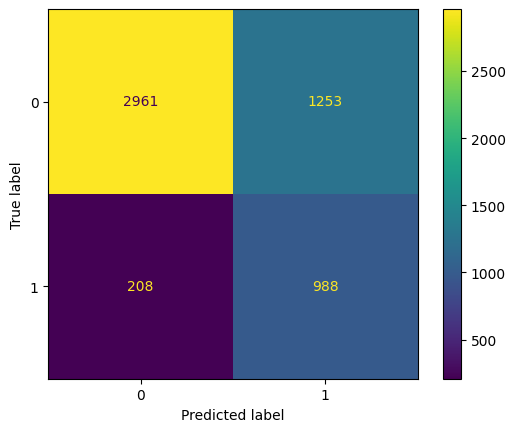

In [ ]:
#look at accuracy, recall, precision chunk_testing_data here
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
recall = recall_score(chunk_testing_data['label'], chunk_testing_data['prediction'])
f1 = f1_score(chunk_testing_data['label'], chunk_testing_data['prediction'])
precision = precision_score(chunk_testing_data['label'], chunk_testing_data['prediction'])
accuracy = accuracy_score(chunk_testing_data['label'], chunk_testing_data['prediction'])

print(f'Stage 1 Accuracy Test Data: {accuracy}')
print(f'Stage 1 Recall Test Data: {recall}')
print(f'Stage 1 Precision Test Data: {precision}')
print(f'Stage 1 f1 Test Data: {f1}')

cm = confusion_matrix(chunk_testing_data['label'], chunk_testing_data['prediction'], labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

In [ ]:
# Filter out for positive predictions only
pos_chunk_prediction_df = chunk_testing_data[chunk_testing_data['prediction'] == 1]
print(len(pos_chunk_prediction_df))
pos_chunk_prediction_df.head()

2241


,Unnamed: 0,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction
2,2,3144,OneSignal,Privacy Policy,"Introduction and Background \nOneSignal, a U.S...",NaN,NaN,0,1
4,4,2315,Fandango,Cookies and Tracking,We and third parties may associate Measurement...,NaN,NaN,0,1
9,9,264,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...,1,1
11,11,2256,Fandom,Privacy Policy,If you connect to a thirdparty service such as...,NaN,NaN,0,1
12,12,616,Pornhub,Privacy Policy,Read the privacy policy of other websites care...,NaN,NaN,0,1


In [ ]:
def count_sentence_scores(df):
  #create list storage to put into column
  all_highlights = []
  #loop through all rows
  for index, row in df.iterrows():
    sentence_scores = []
    chunk_sentences_1 = sent_tokenize(row['doc_text'])
    #for each chunk loop through the sentences
    for sentence_1 in chunk_sentences_1:
      s1_score = 0
      #for each sentence loop through all chunks, sentences to see if theres a match
      for index2, row2 in df.iterrows():
        chunk_sentences_2 = sent_tokenize(row2['doc_text'])
        for sentence_2 in chunk_sentences_2:
          #if match add score to sentence
          if sentence_2 == sentence_1:
            s1_score += 1
      sentence_scores.append(s1_score)
    #take index of max count of sentence_scores
    max_score = max(sentence_scores)
    max_indxs = [i for i, x in enumerate(sentence_scores) if x == max_score]
    max_sentences = ''
    for i in range(len(max_indxs)):
      if i == 0:
        max_sentences += f'{chunk_sentences_1[max_indxs[i]]}'
      else:
        max_sentences += f' {chunk_sentences_1[max_indxs[i]]}'
    all_highlights.append(max_sentences)
  return all_highlights

In [ ]:
pos_chunk_prediction_df['found_highlights'] = count_sentence_scores(pos_chunk_prediction_df) ##### Not sure this is quite right - need to run with data

<ipython-input-16-15e89a3f882b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_chunk_prediction_df['found_highlights'] = count_sentence_scores(pos_chunk_prediction_df) ##### Not sure this is quite right - need to run with data


In [ ]:
pos_chunk_prediction_df

,Unnamed: 0,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction,found_highlights
2,2,3144,OneSignal,Privacy Policy,"Introduction and Background \nOneSignal, a U.S...",NaN,NaN,0,1,"Introduction and Background \nOneSignal, a U.S..."
4,4,2315,Fandango,Cookies and Tracking,We and third parties may associate Measurement...,NaN,NaN,0,1,You can also use the following methods to mana...
9,9,264,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...,1,1,9.4 To reduce the probability of third parties...
11,11,2256,Fandom,Privacy Policy,If you connect to a thirdparty service such as...,NaN,NaN,0,1,If you connect to a thirdparty service such as...
12,12,616,Pornhub,Privacy Policy,Read the privacy policy of other websites care...,NaN,NaN,0,1,Read the privacy policy of other websites care...
...,...,...,...,...,...,...,...,...,...,...
5393,5393,1012,BetterHelp,Privacy Policy,A cookie is a small data file that is transfer...,We use cookies and web beacons to enable the t...,"This service requires first-party cookies, whi...",1,1,A cookie is a small data file that is transfer...
5396,5396,314,Quora,Privacy Policy,"For more information, see the section below ab...","For marketing and promotional purposes, such a...",This service may use your personal information...,1,1,"For more information, see the section below ab..."
5398,5398,2543,Le Parisien,Cookie Policy,Nous vous invitons consulter les politiques d...,Nous vous invitons consulter les politiques d...,The service informs users that its privacy pol...,1,1,Nous vous invitons consulter les politiques d...
5401,5401,291,iCloud,Terms of Service (EU),C.\nNo Conveyance\n\nNothing in this Agreement...,NaN,NaN,0,1,C.\nNo Conveyance\n\nNothing in this Agreement...


In [ ]:
#save to folder
pos_chunk_prediction_df.to_csv(final_data_path + '/predictions/pos_chunk_prediction.csv')

In [ ]:
#read from folder
pos_chunk_prediction_df = pd.read_csv(final_data_path + '/predictions/pos_chunk_prediction.csv')

In [ ]:
#look at number of found highlights == actual highlights here
true_highlight_ratio = len(pos_chunk_prediction_df[pos_chunk_prediction_df['found_highlights'] == pos_chunk_prediction_df['highlight']]) / len(pos_chunk_prediction_df)
highlight_doc_ratio = len(pos_chunk_prediction_df[pos_chunk_prediction_df['found_highlights'] == pos_chunk_prediction_df['doc_text']]) / len(pos_chunk_prediction_df)

print(f'Found Highlights to True Highlights Ratio: {true_highlight_ratio}')
print(f'Found Highlights to Doc Text Ratio: {highlight_doc_ratio}')

Found Highlights to True Highlights Ratio: 0.06961178045515395
Found Highlights to Doc Text Ratio: 0.6492637215528781


# Stage 2

In [ ]:
!pip install --upgrade transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 567.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 18.1 MB/s eta 0:00:00


In [ ]:
# saved_model_path = "/content/drive/MyDrive/266 Final Project/Stage 2/model"
stage_2_model_path = "/content/drive/MyDrive/266 Final Project/Full Orchestration: Stage 1+2/model"

In [ ]:
def paraphrase_text(input_text, segment_name = "policy", save_path = stage_2_model_path):
    """
    Load a pre-trained model and use it to genereate paraphrases for the given text.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = T5Tokenizer.from_pretrained(save_path)
    model = T5ForConditionalGeneration.from_pretrained(save_path).to(device)

    inputs = tokenizer(
        f"Paraphrase the following {segment_name} text while maintaining the same meaning and staying very concise:\n\n{input_text}",
        return_tensors="pt",
        max_length=128,
        truncation=True
    ).to(device)

    outputs = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
def generate_paraphrase_with_gpt(original_text, segment_name="policy"):
    """
    Use OpenAI's GPT model to generate a paraphrase for the given text.
    """
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant trained to paraphrase text while maintaining the same meaning and staying very concise.",
        },
        {
            "role": "user",
            "content": f"Paraphrase the following {segment_name} text:\n\n{original_text}",
        }
    ]

    try:
        response = client.chat.completions.create(
            model="ft:gpt-4o-mini-2024-07-18:personal::Ab0VpOaw",
            messages=messages,
            max_tokens=128,
            temperature=0.9,
        )

        paraphrase = response.choices[0].message.content.strip()
        return paraphrase
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Run Stage 2 Model on Result from Stage 1 Run

In [ ]:
####################### THIS IS THE DATA COMING FROM STAGE 1 ##################################
result_df = pos_chunk_prediction_df[pos_chunk_prediction_df['found_highlights'].isna()==False].reset_index(drop=True)

In [ ]:
# result_df = result_df[['doc_text', 'highlight']]
print(len(result_df))
result_df.head()

2241


,Unnamed: 0.1,Unnamed: 0,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction,found_highlights
0,2,2,3144,OneSignal,Privacy Policy,"Introduction and Background \nOneSignal, a U.S...",NaN,NaN,0,1,"Introduction and Background \nOneSignal, a U.S..."
1,4,4,2315,Fandango,Cookies and Tracking,We and third parties may associate Measurement...,NaN,NaN,0,1,You can also use the following methods to mana...
2,9,9,264,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...,1,1,9.4 To reduce the probability of third parties...
3,11,11,2256,Fandom,Privacy Policy,If you connect to a thirdparty service such as...,NaN,NaN,0,1,If you connect to a thirdparty service such as...
4,12,12,616,Pornhub,Privacy Policy,Read the privacy policy of other websites care...,NaN,NaN,0,1,Read the privacy policy of other websites care...


In [ ]:
# Example usage
index = 2
print("Original Highlight:", result_df['found_highlights'][index],  "\n")
print("Generated Paraphrase:", paraphrase_text(result_df['found_highlights'][index]), "\n")
print("GPT Paraphrase:", generate_paraphrase_with_gpt(result_df['found_highlights'][index]), "\n")

Original Highlight: 9.4 To reduce the probability of third parties gaining unauthorized access, if you login to your account from an unusual server in particular, from a server located in a foreign country, we will block entry to your personal page. 

Generated Paraphrase: This service does not guarantee that it or the products obtained through it meet your expectations or requirements 

GPT Paraphrase: Access might be blocked if unusual login is detected 



In [ ]:
#### Output worksheet to look at results
output_data_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1MEgSz0K_BlkVxwtNqAsA3_YsfjwjzwhGDJEFQrcSUiU/edit?gid=0#gid=0')
stage_2_result_worksheet = output_data_spreadsheet.worksheet('Output 2')

In [ ]:
import evaluate
from bert_score import score
from nltk.translate.bleu_score import sentence_bleu
import spacy
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth_fn = SmoothingFunction().method1

nlp = spacy.load("en_core_web_lg")
rouge = evaluate.load("rouge")

In [ ]:
for index, row in result_df[776:].iterrows():
    original_highlight = row['found_highlights']
    segment_name = row['doc_type']
    gpt_generated = "False"

    # Generate paraphrase using your paraphrasing function
    generated_paraphrase = paraphrase_text(original_highlight, segment_name)

    # Calculate BERTScore
    P, R, F1 = score(
        [generated_paraphrase],
        [original_highlight],
        lang="en"
    )
    bert_score = F1.item()

    # Calculate ROUGE scores
    rouge_score = rouge.compute(
        predictions=[generated_paraphrase],
        references=[original_highlight]
    )

    # Calculate BLEU score with smoothing
    bleu_score = sentence_bleu(
        [original_highlight.split()],
        generated_paraphrase.split(),
        smoothing_function=smooth_fn
    )

    # Calculate spaCy similarity
    original_doc = nlp(original_highlight)
    generated_doc = nlp(generated_paraphrase)
    spacy_similarity = original_doc.similarity(generated_doc)

    # Retry with GPT if BERTScore is below 0.75 or spaCy similarity is below 0.5
    if bert_score < 0.75 or spacy_similarity < 0.5:
        gpt_generated_paraphrase = generate_paraphrase_with_gpt(original_highlight, segment_name)

        # Recalculate BERTScore
        P, R, F1 = score(
            [gpt_generated_paraphrase],
            [original_highlight],
            lang="en"
        )
        gpt_bert_score = F1.item()

        # Recalculate spaCy similarity
        gpt_generated_doc = nlp(gpt_generated_paraphrase)
        gpt_spacy_similarity = original_doc.similarity(gpt_generated_doc)

        # Compare GPT-generated paraphrase with the original
        print("\n\n")
        print(f"original_highlight: {original_highlight}")
        print(f"generated_paraphrase: {generated_paraphrase}")
        print(f"BERTScore: {bert_score}")
        print(f"spacy_similarity: {spacy_similarity}")
        print(f"gpt_generated_paraphrase: {gpt_generated_paraphrase}")
        print(f"gpt_BERTScore: {gpt_bert_score}")
        print(f"gpt_spacy_similarity: {gpt_spacy_similarity}")
        print("\n")

        # Choose GPT paraphrase if it has a higher BERT or spaCy similarity score
        if gpt_bert_score > bert_score or gpt_spacy_similarity > spacy_similarity:
            generated_paraphrase = gpt_generated_paraphrase
            bert_score = gpt_bert_score
            spacy_similarity = gpt_spacy_similarity
            gpt_generated = "True"
            print("Using GPT paraphrase")

    # Store results in the DataFrame
    result_df.at[index, 'generated_paraphrase'] = generated_paraphrase
    result_df.at[index, 'bert_score'] = bert_score
    result_df.at[index, 'rouge_1'] = rouge_score['rouge1']
    result_df.at[index, 'rouge_2'] = rouge_score['rouge2']
    result_df.at[index, 'rouge_l'] = rouge_score['rougeL']
    result_df.at[index, 'bleu_score'] = bleu_score
    result_df.at[index, 'spacy_similarity'] = spacy_similarity
    result_df.at[index, 'gpt_generated'] = gpt_generated

    # Push to Google Sheets every 25 rows
    if index % 25 == 0 and index != 0:
        set_with_dataframe(stage_2_result_worksheet, result_df)
        time.sleep(10)

# Final push to Google Sheets
set_with_dataframe(stage_2_result_worksheet, result_df)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]




original_highlight: Utilisateurs de la classe virtuelle nbsp. Nom, prnom, session, rle, heures dentres et de sortie, exclusion ventuelle de la classe, et adresse IP 
La conservation des donnes relatives  lorganisation des classes virtuelles est ralise en application de lobligation lgale pose par les articles 6 de la Loi n2004575 du 21 juin 2004 et le dcret 2011219 du 25 fvrier 2011. Aucune utilisation commerciale des donnes nest ralise par le CNED.
generated_paraphrase: The service provides information about how they intend to use the service
BERTScore: 0.7825956344604492
spacy_similarity: 0.15988949712051626
gpt_generated_paraphrase: The CNED does not monetize user data
gpt_BERTScore: 0.7894136905670166
gpt_spacy_similarity: 0.047550004539874846


Using GPT paraphrase



original_highlight: YOU AGREE THAT IF ANYONE BRINGS A CLAIM AGAINST SPOTIFY RELATED TO USER CONTENT THAT YOU POST, THEN, TO THE EXTENT PERMISSIBLE UNDER LOCAL LAW, YOU WILL INDEMNIFY AND HOLD SPOTIFY HARMLESS FROM 

# Stage 2 Analysis

In [ ]:
results_df = get_as_dataframe(stage_2_result_worksheet)
results_df.head()

,Unnamed: 0.1,Unnamed: 0,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction,found_highlights,generated_paraphrase,bert_score,rouge_1,rouge_2,rouge_l,bleu_score,spacy_similarity,gpt_generated
0,2,2,3144,OneSignal,Privacy Policy,"Introduction and Background \nOneSignal, a U.S...",NaN,NaN,0,1,"Introduction and Background \nOneSignal, a U.S...",The service provides information about how the...,0.821302,0.134454,0.017094,0.084034,0.000037,0.888006,False
1,4,4,2315,Fandango,Cookies and Tracking,We and third parties may associate Measurement...,NaN,NaN,0,1,You can also use the following methods to mana...,You can use this service to track your progress,0.920526,0.421053,0.117647,0.421053,0.053965,0.932752,False
2,9,9,264,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...,1,1,9.4 To reduce the probability of third parties...,This service does not guarantee that it or the...,0.799838,0.068966,0.000000,0.068966,0.004000,0.835372,False
3,11,11,2256,Fandom,Privacy Policy,If you connect to a thirdparty service such as...,NaN,NaN,0,1,If you connect to a thirdparty service such as...,The service may share your personal data with ...,0.835929,0.156250,0.015873,0.109375,0.000077,0.915629,False
4,12,12,616,Pornhub,Privacy Policy,Read the privacy policy of other websites care...,NaN,NaN,0,1,Read the privacy policy of other websites care...,This service assumes no liability for any loss...,0.828122,0.192308,0.000000,0.153846,0.006641,0.840446,False


### Limiting evaluation to ONLY those with a PARAPHRASE to compare to

In [ ]:
results_df = results_df[results_df['paraphrase'].isna()==False]

## Rouge

In [ ]:
# Load the metric
rouge = evaluate.load("rouge")

# Compute ROUGE scores
results = rouge.compute(
    predictions=results_df['generated_paraphrase'].tolist(),
    references=results_df['paraphrase'].tolist()
)

print(results)

{'rouge1': 0.29636751534101335, 'rouge2': 0.15942625407220098, 'rougeL': 0.2727387646401212, 'rougeLsum': 0.27270504510927573}


## Bleu

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Smoothing function
smooth_fn = SmoothingFunction().method1

# Prepare tokenized references and candidates
references = [[ref.split()] for ref in results_df['paraphrase'].tolist()]
candidates = [str(cand).split() for cand in results_df['generated_paraphrase'].tolist()]

# Compute BLEU score
overall_bleu_score = corpus_bleu(references, candidates, smoothing_function=smooth_fn)

# Print the overall BLEU score
print(f"Overall BLEU Score: {overall_bleu_score:.4f}")

Overall BLEU Score: 0.1339


## Meteor

In [ ]:
# Load METEOR metric
meteor = evaluate.load("meteor")

# Compute METEOR scores
results = meteor.compute(
    predictions=results_df['generated_paraphrase'].tolist(),
    references=results_df['paraphrase'].tolist()
)

# Print the results
print(results)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.26024484746715465}


## BERT

In [ ]:
from bert_score import score

P, R, F1 = score(
    results_df['generated_paraphrase'].astype(str).tolist(),
    results_df['paraphrase'].astype(str).tolist(),
    lang="en"
)

results_df['BERTScore P<>GP'] = F1.numpy()

overall_bert_score = F1.mean().item()
print(f"Overall BERTScore P<>GP (F1): {overall_bert_score:.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Overall BERTScore P<>GP (F1): 0.8729


## SpaCy

In [ ]:
import spacy

# Load the spaCy model (use a model with word vectors, e.g., 'en_core_web_md' or 'en_core_web_lg')
nlp = spacy.load("en_core_web_lg")

# Ensure all values are strings
generated_paraphrases = results_df['generated_paraphrase'].astype(str).tolist()
paraphrases = results_df['paraphrase'].astype(str).tolist()

# Calculate spaCy similarity for each pair
spacy_scores = []

for gen, ref in zip(generated_paraphrases, paraphrases):
    gen_doc = nlp(gen)
    ref_doc = nlp(ref)
    similarity = gen_doc.similarity(ref_doc)
    spacy_scores.append(similarity)

# Add individual spaCy scores to the DataFrame
results_df['spaCy Similarity'] = spacy_scores

# Compute the overall spaCy similarity score
overall_spacy_score = sum(spacy_scores) / len(spacy_scores)

print(f"Overall spaCy Similarity Score: {overall_spacy_score:.4f}")

Overall spaCy Similarity Score: 0.8095


# GPT Analysis
This analysis is left out of the report because it misleadingly displays lower results - GPT was only fed the hardest highlights to paraphrase so it is expected for these scores to be lower.

In [ ]:
gpt_results_df = results_df[results_df['gpt_generated']==True].reset_index(drop=True)
print(len(gpt_results_df))
gpt_results_df.head()

71


,Unnamed: 0.1,Unnamed: 0,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction,...,generated_paraphrase,bert_score,rouge_1,rouge_2,rouge_l,bleu_score,spacy_similarity,gpt_generated,BERTScore P<>GP,spaCy Similarity
0,28,28,2544,El País,Privacy Policy,Se recomienda que el usuario facilite toda la ...,El Usuario tendr derecho a formular una queja ...,A complaint mechanism is provided for the hand...,1,1,...,The user can exercise their rights in relation...,0.787422,0.000000,0.000000,0.000000,0.0,0.041282,True,0.890878,0.741938
1,43,43,2909,Replika,Terms of Service,Disclaimer of warranties\nYOUR USE OF THE SERV...,THE SERVICE IS PROVIDED ON AN AS IS AND AS AVA...,The service is provided 'as is' and to be used...,1,1,...,Service providers are not responsible for damages,0.770572,0.338028,0.173913,0.253521,0.0,0.285313,True,0.824113,0.733752
2,148,148,444,Heaven HR,Datenschutzerklärung (Privacy Policy),"Sie knnen Ihren Browser so einstellen, dass er...","Sie knnen Ihren Browser so einstellen, dass er...",Blocking first party cookies may limit your ab...,1,1,...,You can configure your browser to prevent cook...,0.784420,0.000000,0.000000,0.000000,0.0,0.341524,True,0.865869,0.898476
3,165,165,2544,El País,Privacy Policy,Estos datos estarn vinculados principalmente a...,"De esta forma, El Pas podr vincular a dichos d...",The service uses your personal data for advert...,1,1,...,The service collects data about user content,0.792828,0.000000,0.000000,0.000000,0.0,0.157550,True,0.902576,0.893812
4,206,206,616,Pornhub,Terms & Conditions,httpssupport.pornhubpremium.com. Some promotio...,We are not responsible for the products and se...,The service is not responsible for linked or (...,1,1,...,The terms of service of Pornhub Premium,0.842713,0.000000,0.000000,0.000000,0.0,0.346663,True,0.781206,0.640269


## GPT Rouge

In [ ]:
# Load the metric
# Compute ROUGE scores
results = rouge.compute(
    predictions=gpt_results_df['generated_paraphrase'].tolist(),
    references=gpt_results_df['paraphrase'].tolist()
)

print(results)

{'rouge1': 0.2160503594208124, 'rouge2': 0.05114382580962257, 'rougeL': 0.1818212353299602, 'rougeLsum': 0.1836386442101906}


## GPT Bleu

In [ ]:
# Smoothing function
smooth_fn = SmoothingFunction().method1

# Prepare tokenized references and candidates
references = [[ref.split()] for ref in gpt_results_df['paraphrase'].tolist()]
candidates = [str(cand).split() for cand in gpt_results_df['generated_paraphrase'].tolist()]

# Compute BLEU score
overall_bleu_score = corpus_bleu(references, candidates, smoothing_function=smooth_fn)

# Print the overall BLEU score
print(f"Overall BLEU Score: {overall_bleu_score:.4f}")

Overall BLEU Score: 0.0241


## GPT Meteor

In [ ]:
# Load METEOR metric
meteor = evaluate.load("meteor")

# Compute METEOR scores
results = meteor.compute(
    predictions=gpt_results_df['generated_paraphrase'].tolist(),
    references=gpt_results_df['paraphrase'].tolist()
)

# Print the results
print(results)

{'meteor': 0.16720369697341145}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## GPT BERT

In [ ]:
from bert_score import score

P, R, F1 = score(
    gpt_results_df['generated_paraphrase'].astype(str).tolist(),
    gpt_results_df['paraphrase'].astype(str).tolist(),
    lang="en"
)

overall_bert_score = F1.mean().item()
print(f"GPT BERTScore P<>GP (F1): {overall_bert_score:.4f}")

GPT BERTScore P<>GP (F1): 0.8573


## GPT SpaCy

In [ ]:
# Ensure all values are strings
generated_paraphrases = gpt_results_df['generated_paraphrase'].astype(str).tolist()
paraphrases = gpt_results_df['paraphrase'].astype(str).tolist()

# Calculate spaCy similarity for each pair
spacy_scores = []

for gen, ref in zip(generated_paraphrases, paraphrases):
    gen_doc = nlp(gen)
    ref_doc = nlp(ref)
    similarity = gen_doc.similarity(ref_doc)
    spacy_scores.append(similarity)

# Compute the overall spaCy similarity score
overall_spacy_score = sum(spacy_scores) / len(spacy_scores)

print(f"Overall spaCy Similarity Score: {overall_spacy_score:.4f}")

Overall spaCy Similarity Score: 0.7658


# Segment / Bias Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
data_spreadsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/12C-A9wGs-5snsP5_P9kKj0iZzXZS5cr0lBL-AhMX8Qc/edit?gid=0#gid=0")
mapping_ws = data_spreadsheet.worksheet("Type Mapping")
mapping_df = get_as_dataframe(mapping_ws, evaluate_formulas=True)
mapping_df.head()

,doc_type,segment_type
0,Content Policy,Other
1,Digital Millennium Copyright Act (DMCA) Notic...,Other
2,Terms and Conditions,Terms
3,2FA,Other
4,About Cookies,Cookie Policy


In [ ]:
results_segment_df = results_df.merge(mapping_df, on="doc_type", how="left")
results_segment_df.head()

,Unnamed: 0.1,Unnamed: 0,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,prediction,...,bert_score,rouge_1,rouge_2,rouge_l,bleu_score,spacy_similarity,gpt_generated,BERTScore P<>GP,spaCy Similarity,segment_type
0,9,9,264,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...,1,1,...,0.799838,0.068966,0.000000,0.068966,0.004000,0.835372,False,0.835613,0.773976,Privacy Policy
1,13,13,616,Pornhub,Terms & Conditions,You are fully responsible for all activities t...,You are fully responsible for all activities t...,You are responsible for maintaining the securi...,1,1,...,0.907655,0.375000,0.133333,0.375000,0.038071,0.859078,False,1.000000,1.000000,Terms
2,15,15,403,Fur Affinity,Terms of Service,We retain the right to create limits on our se...,"We may change, suspend, or discontinue any or ...",They may stop providing the service at any time,1,1,...,0.830989,0.144578,0.000000,0.120482,0.000290,0.880145,False,0.843717,0.825197,Terms
3,17,17,2947,Skillshare,Terms of Service,We have the right to terminate your membership...,We have the right to terminate your membership...,Your account can be deleted without prior noti...,1,1,...,0.849976,0.212121,0.031250,0.151515,0.000943,0.870618,False,0.958280,0.930372,Terms
4,28,28,2544,El País,Privacy Policy,Se recomienda que el usuario facilite toda la ...,El Usuario tendr derecho a formular una queja ...,A complaint mechanism is provided for the hand...,1,1,...,0.787422,0.000000,0.000000,0.000000,0.000000,0.041282,True,0.890878,0.741938,Privacy Policy


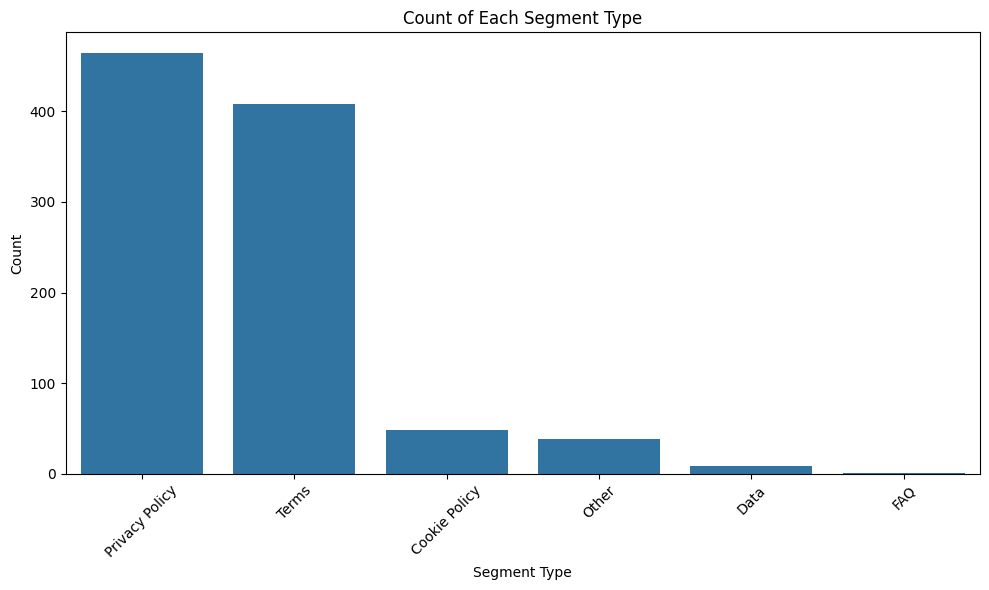

In [ ]:
# Count the number of occurrences for each segment type
segment_counts = results_segment_df["segment_type"].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title("Count of Each Segment Type")
plt.xlabel("Segment Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
segment_counts = segment_counts.reset_index()
segment_counts['perc'] = segment_counts['count']/segment_counts['count'].sum()
segment_counts

,segment_type,count,perc
0,Privacy Policy,464,0.479835
1,Terms,408,0.421923
2,Cookie Policy,48,0.049638
3,Other,38,0.039297
4,Data,8,0.008273
5,FAQ,1,0.001034


## BERT Score by Doc Type

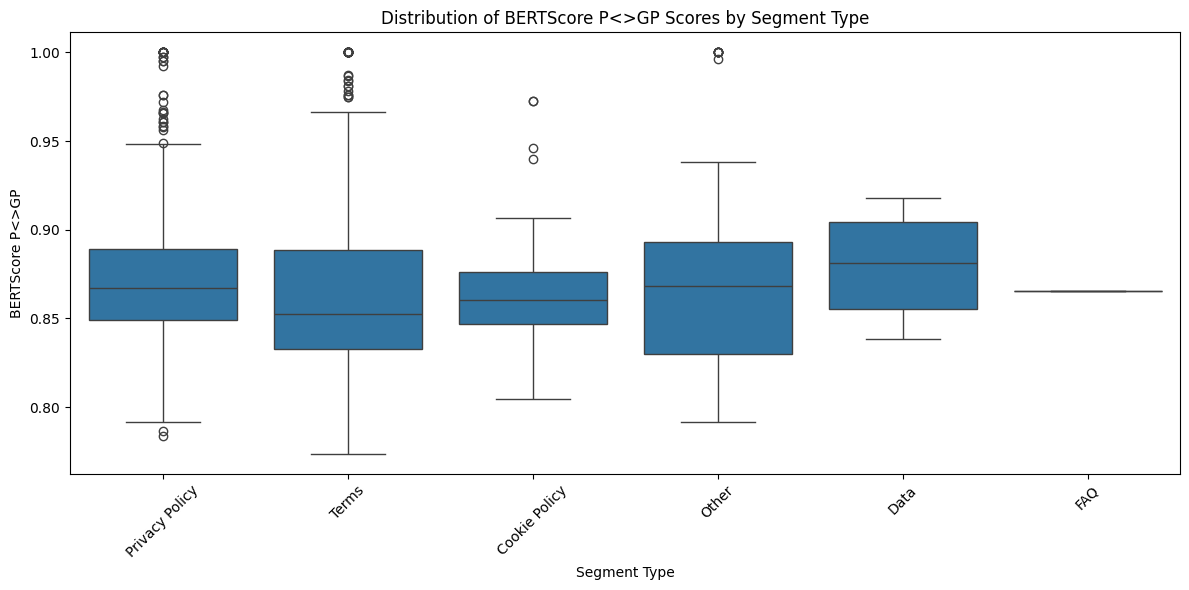

In [ ]:
# Plot the distribution of BERTScore P<>GP scores by segment type
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_segment_df, x="segment_type", y="BERTScore P<>GP")
plt.title("Distribution of BERTScore P<>GP Scores by Segment Type")
plt.xlabel("Segment Type")
plt.ylabel("BERTScore P<>GP")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

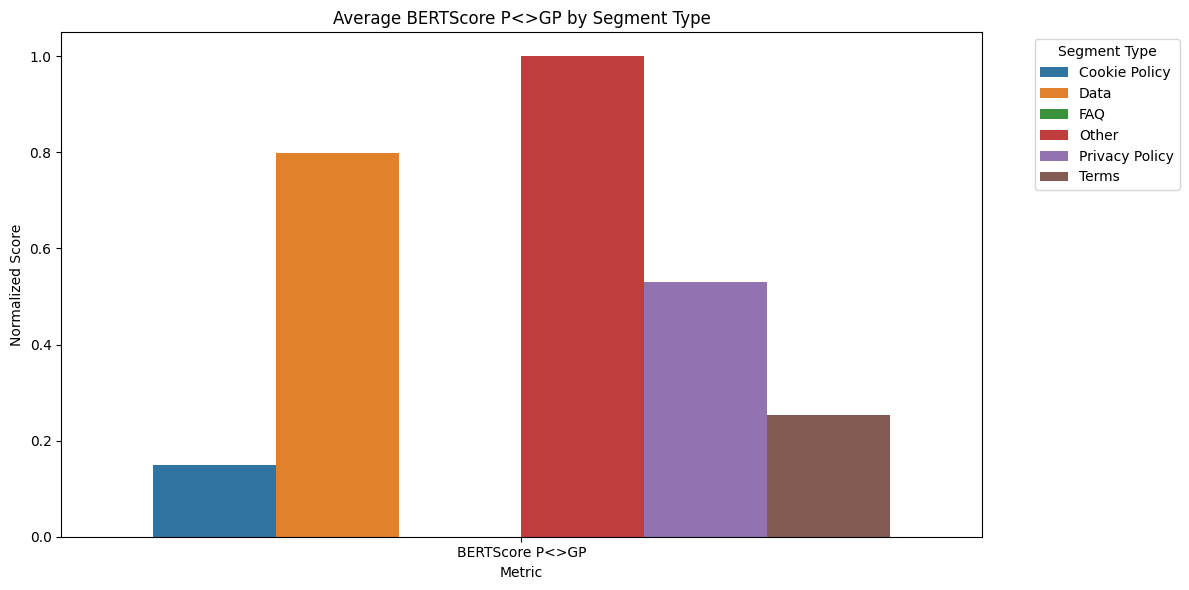

In [ ]:
# Group the data by segment_type and calculate the mean for BERTScore P<>GP
grouped_bertscore_df = results_segment_df.groupby("segment_type")[["BERTScore P<>GP"]].mean().reset_index()

# Normalize the BERTScore P<>GP scores
grouped_bertscore_df[["BERTScore P<>GP"]] = scaler.fit_transform(grouped_bertscore_df[["BERTScore P<>GP"]])

# Melt the DataFrame for easier plotting
melted_bertscore_df = grouped_bertscore_df.melt(
    id_vars=["segment_type"],
    value_vars=["BERTScore P<>GP"],
    var_name="Metric",
    value_name="Score"
)

# Plotting BERTScore P<>GP
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_bertscore_df, x="Metric", y="Score", hue="segment_type")

plt.title("Average BERTScore P<>GP by Segment Type")
plt.xlabel("Metric")
plt.ylabel("Normalized Score")
plt.legend(title="Segment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## SpaCy Score by Doc Type

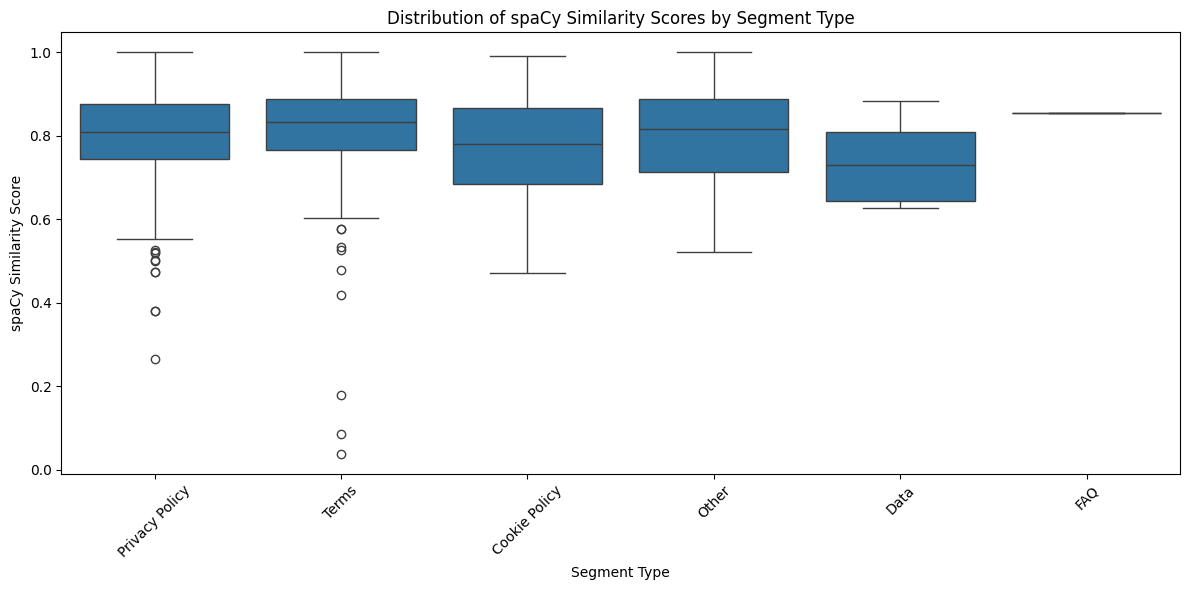

In [ ]:
# Plot the distribution of spaCy Similarity scores by segment type
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_segment_df, x="segment_type", y="spaCy Similarity")
plt.title("Distribution of spaCy Similarity Scores by Segment Type")
plt.xlabel("Segment Type")
plt.ylabel("spaCy Similarity Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

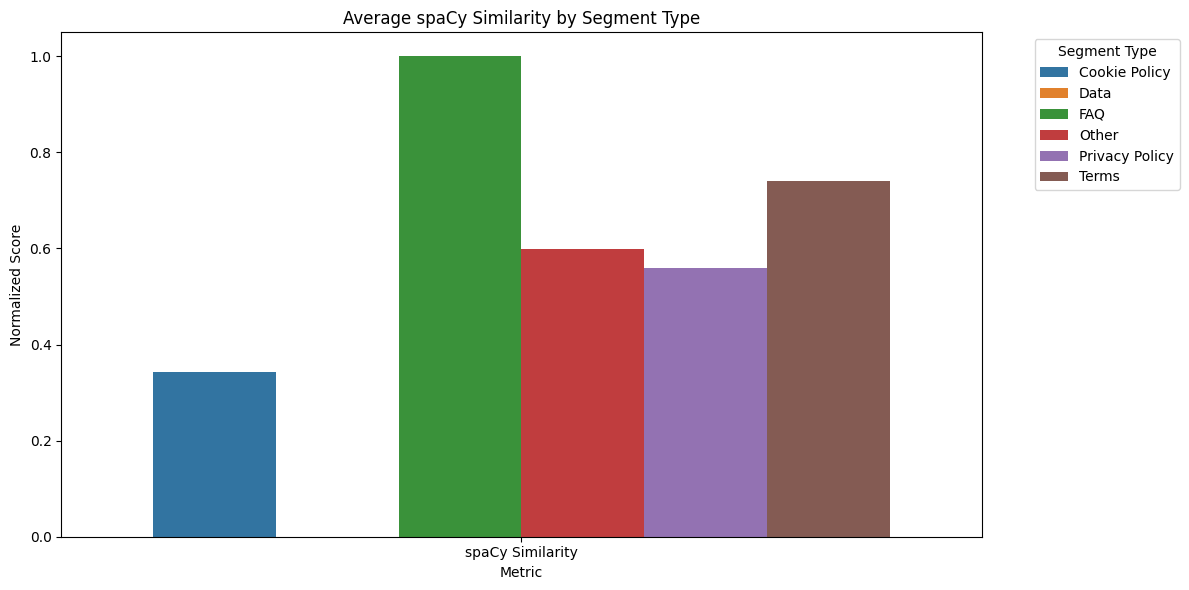

In [ ]:
# Group the data by segment_type and calculate the mean for spaCy Similarity
grouped_spacy_df = results_segment_df.groupby("segment_type")[["spaCy Similarity"]].mean().reset_index()

# Normalize the spaCy Similarity scores
grouped_spacy_df[["spaCy Similarity"]] = scaler.fit_transform(grouped_spacy_df[["spaCy Similarity"]])

# Melt the DataFrame for easier plotting
melted_spacy_df = grouped_spacy_df.melt(
    id_vars=["segment_type"],
    value_vars=["spaCy Similarity"],
    var_name="Metric",
    value_name="Score"
)

# Plotting spaCy Similarity
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_spacy_df, x="Metric", y="Score", hue="segment_type")

plt.title("Average spaCy Similarity by Segment Type")
plt.xlabel("Metric")
plt.ylabel("Normalized Score")
plt.legend(title="Segment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Compare Segments

In [ ]:
# Group by segment_type and calculate count, mean, and median for both metrics
summary_stats = results_segment_df.groupby("segment_type")[["spaCy Similarity", "BERTScore P<>GP"]].agg(["count", "mean", "median"]).reset_index()

# Flatten the multi-level columns
summary_stats.columns = ["Segment Type",
                         "Count", "spaCy Mean", "spaCy Median",
                         "BERTScore Count", "BERTScore Mean", "BERTScore Median"]

summary_stats.drop("BERTScore Count", axis=1, inplace=True)
# Sort the summary by the spaCy Mean and BERTScore Mean in descending order
sorted_summary = summary_stats.sort_values(by=["Count"], ascending=False)

sorted_summary

,Segment Type,Count,spaCy Mean,spaCy Median,BERTScore Mean,BERTScore Median
4,Privacy Policy,464,0.802417,0.809383,0.874778,0.867360
5,Terms,408,0.823979,0.832107,0.869948,0.852409
0,Cookie Policy,48,0.776614,0.779844,0.868172,0.860226
3,Other,38,0.807153,0.816316,0.882941,0.868237
1,Data,8,0.735828,0.729892,0.879444,0.881306
2,FAQ,1,0.854983,0.854983,0.865560,0.865560


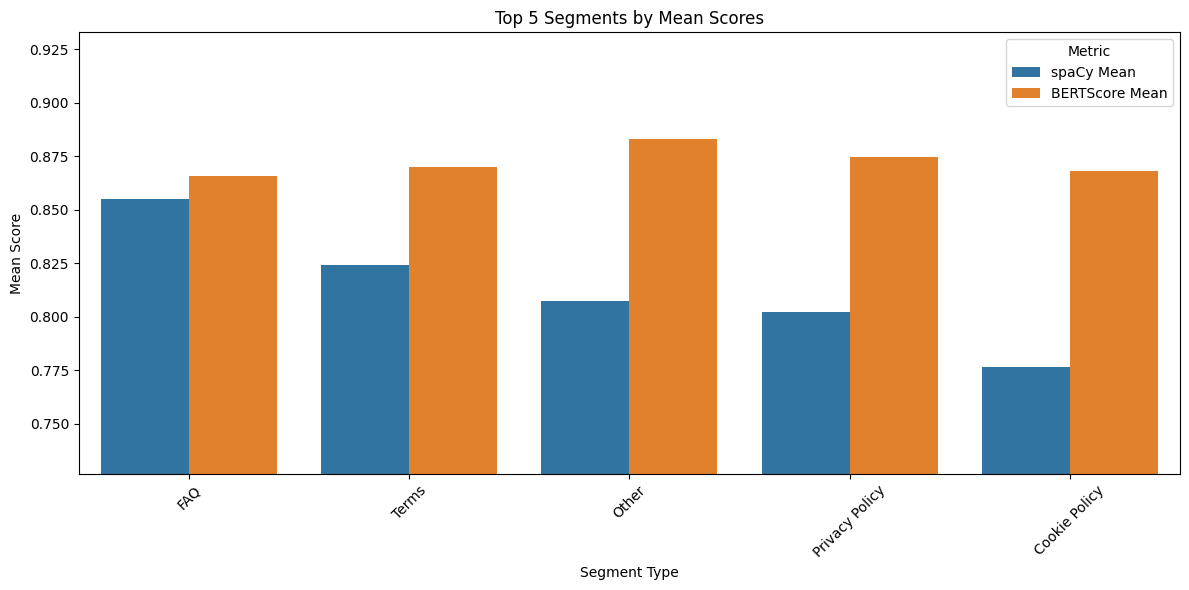

In [ ]:
# Plot the mean scores for the top 5 segments
top_5_segments = sorted_summary.head(5)

# Melt the DataFrame for plotting
melted_top_5 = top_5_segments.melt(id_vars=["Segment Type"], value_vars=["spaCy Mean", "BERTScore Mean"])

# Determine the minimum and maximum values for the y-axis
y_min = melted_top_5["value"].min() - 0.05  # Adding a small buffer below the min
y_max = melted_top_5["value"].max() + 0.05  # Adding a small buffer above the max

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_top_5, x="Segment Type", y="value", hue="variable")

# Set custom y-axis limits
plt.ylim(y_min, y_max)

plt.title("Top 5 Segments by Mean Scores")
plt.xlabel("Segment Type")
plt.ylabel("Mean Score")
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Distribution

In [ ]:
training_data_spreadsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1YcGOvY4HN6o1Dt5Q8R3yzSolkfKnT9dHPm9iCqXJTe4/edit?gid=457380158#gid=457380158")
trainding_data_ws = training_data_spreadsheet.get_worksheet(0)
training_data_df = get_as_dataframe(trainding_data_ws, evaluate_formulas=True)

training_data_df = training_data_df[training_data_df['paraphrase'].isna() == False]
print(len(training_data_df))

training_data_df = training_data_df.merge(mapping_df, on="doc_type", how="left")
training_data_df.head()

4784


,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,segment_type
0,1588.0,Coinbase,CB Payments & COINBASE UK PRIVACY POLICY,"With law enforcement, officials, or other thir...","With law enforcement, officials, or other thir...",This service reserves the right to disclose yo...,1.0,Privacy Policy
1,831.0,Clockify,Terms of Use,AGREEMENT AMENDMENTS COING may revise and upda...,Any changes shall enter into force upon being ...,"When the service wants to change its terms, us...",1.0,Terms
2,1593.0,ISODME,Privacy Policy,Tracking technologies and Cookies. We use cook...,"We use cookies, beacons, tags, scripts and oth...","The service may use tracking pixels, web beaco...",1.0,Privacy Policy
3,185.0,Netflix,Terms of Use,The member who created the Netflix account and...,You are responsible for updating and maintaini...,"You must provide your legal name, pseudonyms a...",1.0,Terms
4,836.0,Scratch,"Privacy Policy (February 14, 2019)",Parents and guardians who register their under...,The results of this research are shared with e...,Your personal data is aggregated into statistics,1.0,Privacy Policy


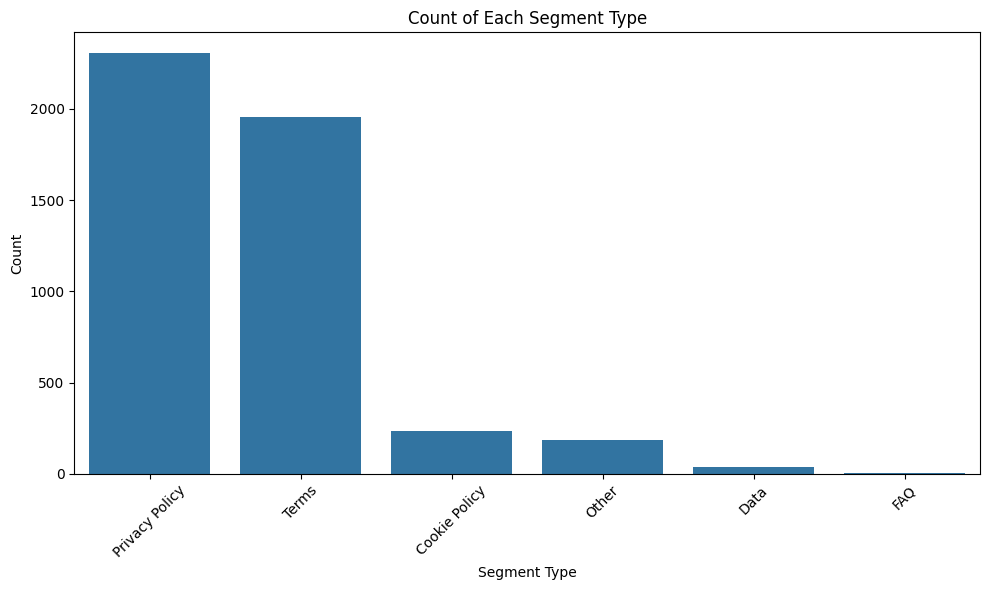

In [ ]:
# Count the number of occurrences for each segment type
segment_counts = training_data_df["segment_type"].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title("Count of Each Segment Type")
plt.xlabel("Segment Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
segment_counts = segment_counts.reset_index()
segment_counts['perc'] = segment_counts['count']/segment_counts['count'].sum()
segment_counts

,segment_type,count,perc
0,Privacy Policy,2304,0.488550
1,Terms,1956,0.414758
2,Cookie Policy,232,0.049194
3,Other,186,0.039440
4,Data,36,0.007634
5,FAQ,2,0.000424


In [ ]:
testing_data_spreadsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1Uho60wnU9C-cLqUBC3VM4v0Q_S9I4DRMvmcEspdK4U8/edit?gid=338078967#gid=338078967")
testing_data_ws = testing_data_spreadsheet.get_worksheet(0)
testing_data_df = get_as_dataframe(testing_data_ws, evaluate_formulas=True)

testing_data_df = testing_data_df[testing_data_df['paraphrase'].isna() == False]
print(len(testing_data_df))

testing_data_df = testing_data_df.merge(mapping_df, on="doc_type", how="left")
testing_data_df.head()

1196


,service_id,service_name,doc_type,doc_text,highlight,paraphrase,label,segment_type
0,264.0,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...,1.0,Privacy Policy
1,616.0,Pornhub,Terms & Conditions,You are fully responsible for all activities t...,You are fully responsible for all activities t...,You are responsible for maintaining the securi...,1.0,Terms
2,403.0,Fur Affinity,Terms of Service,We retain the right to create limits on our se...,"We may change, suspend, or discontinue any or ...",They may stop providing the service at any time,1.0,Terms
3,2947.0,Skillshare,Terms of Service,We have the right to terminate your membership...,We have the right to terminate your membership...,Your account can be deleted without prior noti...,1.0,Terms
4,2544.0,El País,Privacy Policy,Se recomienda que el usuario facilite toda la ...,El Usuario tendr derecho a formular una queja ...,A complaint mechanism is provided for the hand...,1.0,Privacy Policy


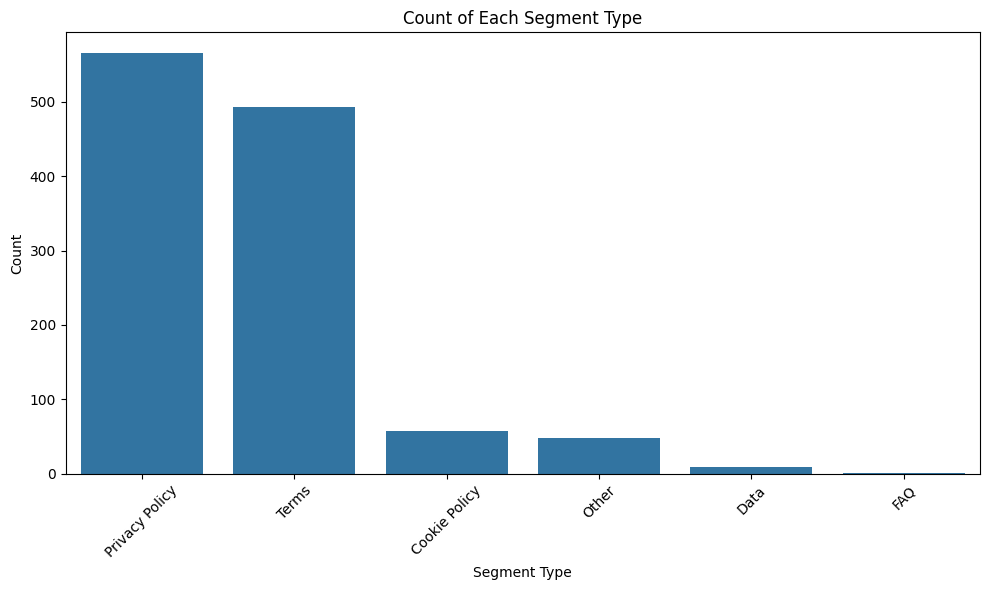

In [ ]:
# Count the number of occurrences for each segment type
segment_counts = testing_data_df["segment_type"].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title("Count of Each Segment Type")
plt.xlabel("Segment Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
segment_counts = segment_counts.reset_index()
segment_counts['perc'] = segment_counts['count']/segment_counts['count'].sum()
segment_counts

,segment_type,count,perc
0,Privacy Policy,565,0.481671
1,Terms,493,0.420290
2,Cookie Policy,57,0.048593
3,Other,48,0.040921
4,Data,9,0.007673
5,FAQ,1,0.000853
